In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from PIL import Image
from glob import glob
from matplotlib import pyplot as plt

import os

In [2]:
dataset_path = '/kaggle/input/lu3m6tgt/LU3M6TGT_yolo_format'
train_path = f'{dataset_path}/train/images'
valid_path = f'{dataset_path}/valid/images'

ckpt_dir = '/kaggle/working/Model'
ckpt_path = f'{ckpt_dir}/AutoEncoder.keras'
if not os.path.exists(ckpt_path):
    os.makedirs(ckpt_dir)

In [3]:
def load_images(file):
    im = Image.open(file).resize((144, 144), Image.Resampling.LANCZOS)
    return np.array(im, dtype="float32") / 255.0

def load_images_data(filepath):
    names = glob(os.path.join(filepath) + '/*.*')
    return np.array([load_images(names[i]) for i in range(len(names))])

def add_noise(img):
    grain_intensity = 0.05
    noise = np.random.normal(loc=0, scale=grain_intensity, size=img.shape)
    img = img + noise
    img = np.clip(img, 0, 1)
    
    return img

In [4]:
x_train = load_images_data(train_path)
x_test = load_images_data(valid_path)

x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)

In [5]:
'''
# https://github.com/rudraxix/SIH/blob/main/autoedit.py

from PIL import Image, ImageEnhance
import os
import numpy as np


def adjust_brightness_contrast_grain(input_folder, output_folder, grain_intensity=1.0, brightness_factor=1.0, contrast_factor=1.0):
    # Create the output directory if not there
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    
    # Looping over all files in the input directory
    for filename in os.listdir(input_folder):
        if filename.endswith((".jpg", ".jpeg", ".png")):  # Process only image files
            img_path = os.path.join(input_folder, filename)
            img = Image.open(img_path)

            # Adjust brightness
            enhancer = ImageEnhance.Brightness(img)
            img = enhancer.enhance(brightness_factor)

            # Adjust contrast
            enhancer = ImageEnhance.Contrast(img)
            img = enhancer.enhance(contrast_factor)

            #Adjust grain
            img_array = np.array(img)
            noise = np.random.normal(loc=0, scale=grain_intensity*255, size=img_array.shape)
            img_array = img_array + noise
            img_array = np.clip(img_array, 0, 255).astype(np.uint8)
            img_with_grain = Image.fromarray(img_array)

            # Save the modified image to the output directory
            output_path = os.path.join(output_folder, filename)
            img.save(output_path)

            #print(f"Edited the {filename} and saved it to {output_path}")

def create_images(input_folder, output_folder):
    # set Parameters
    brightness_factor = 0.3  # Decreased brightness by x%
    contrast_factor = 1.0   # Increased contrast by x%
    grain_intensity= 1.0 #Added grain
    
    adjust_brightness_contrast_grain(input_folder, output_folder, brightness_factor, contrast_factor, grain_intensity)    
'''

'\n# https://github.com/rudraxix/SIH/blob/main/autoedit.py\n\nfrom PIL import Image, ImageEnhance\nimport os\nimport numpy as np\n\n\ndef adjust_brightness_contrast_grain(input_folder, output_folder, grain_intensity=1.0, brightness_factor=1.0, contrast_factor=1.0):\n    # Create the output directory if not there\n    if not os.path.exists(output_folder):\n        os.makedirs(output_folder)\n    \n    \n    # Looping over all files in the input directory\n    for filename in os.listdir(input_folder):\n        if filename.endswith((".jpg", ".jpeg", ".png")):  # Process only image files\n            img_path = os.path.join(input_folder, filename)\n            img = Image.open(img_path)\n\n            # Adjust brightness\n            enhancer = ImageEnhance.Brightness(img)\n            img = enhancer.enhance(brightness_factor)\n\n            # Adjust contrast\n            enhancer = ImageEnhance.Contrast(img)\n            img = enhancer.enhance(contrast_factor)\n\n            #Adjust grain

In [6]:
'''
create_images(train_path, '/kaggle/working/noise/train')
create_images(valid_path, '/kaggle/working/noise/valid')
'''

"\ncreate_images(train_path, '/kaggle/working/noise/train')\ncreate_images(valid_path, '/kaggle/working/noise/valid')\n"

In [7]:
'''
x_train = tf.keras.utils.image_dataset_from_directory(
                train_path,
                labels = None,
                label_mode = None,
                image_size = (256, 256),
                batch_size = 32
            )
x_test = tf.keras.utils.image_dataset_from_directory(
                valid_path,
                labels = None,
                label_mode = None,
                image_size = (256, 256),
                batch_size = 32
            )
x_train_noisy = tf.keras.utils.image_dataset_from_directory(
                '/kaggle/working/noise/train',
                labels = None,
                label_mode = None,
                image_size = (256, 256),
                batch_size = 32
            )
x_test_noisy = tf.keras.utils.image_dataset_from_directory(
                '/kaggle/working/noise/valid',
                labels = None,
                label_mode = None,
                image_size = (256, 256),
                batch_size = 32
            )
'''

"\nx_train = tf.keras.utils.image_dataset_from_directory(\n                train_path,\n                labels = None,\n                label_mode = None,\n                image_size = (256, 256),\n                batch_size = 32\n            )\nx_test = tf.keras.utils.image_dataset_from_directory(\n                valid_path,\n                labels = None,\n                label_mode = None,\n                image_size = (256, 256),\n                batch_size = 32\n            )\nx_train_noisy = tf.keras.utils.image_dataset_from_directory(\n                '/kaggle/working/noise/train',\n                labels = None,\n                label_mode = None,\n                image_size = (256, 256),\n                batch_size = 32\n            )\nx_test_noisy = tf.keras.utils.image_dataset_from_directory(\n                '/kaggle/working/noise/valid',\n                labels = None,\n                label_mode = None,\n                image_size = (256, 256),\n                batch_siz

In [8]:
'''
import shutil
shutil.rmtree('/kaggle/working/noise')
'''

"\nimport shutil\nshutil.rmtree('/kaggle/working/noise')\n"

In [9]:
class Denoise(Model):
    def __init__(self):
        super().__init__()
        
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(144, 144, 3)),
            #layers.Rescaling(1./255),
            #layers.Conv2D(256, (3, 3), activation='relu', padding='same', strides=2),
            #layers.BatchNormalization(axis=3),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2),
            layers.BatchNormalization(axis=3),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
            layers.BatchNormalization(axis=3),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
            layers.BatchNormalization(axis=3),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
            layers.BatchNormalization(axis=3),
            #layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2),
            #layers.BatchNormalization(axis=3)
        ])

        self.decoder = tf.keras.Sequential([
            #layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(128, kernel_size=3, strides=2, activation='relu', padding='same'),
            #layers.Conv2DTranspose(256, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same'),
            layers.BatchNormalization(axis=3)
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return decoded

autoencoder = Denoise()

In [10]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(), loss=losses.MeanSquaredError())

In [11]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(ckpt_path, verbose=1, monitor='val_loss', mode='min', save_best_only=False)

In [12]:
history = autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[cp_callback])

Epoch 1/100


I0000 00:00:1725561955.065824    1504 service.cc:145] XLA service 0x7b1310048a20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725561955.065881    1504 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  3/274 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - loss: 0.1213

I0000 00:00:1725561962.324229    1504 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0286
Epoch 1: saving model to /kaggle/working/Model/AutoEncoder.keras
274/274 ━━━━━━━━━━━━━━━━━━━━ 35s 87ms/step - loss: 0.0285 - val_loss: 0.0044
Epoch 2/100
273/274 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0037
Epoch 2: saving model to /kaggle/working/Model/AutoEncoder.keras
274/274 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 3/100
273/274 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0025
Epoch 3: saving model to /kaggle/working/Model/AutoEncoder.keras
274/274 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 4/100
273/274 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0022
Epoch 4: saving model to /kaggle/working/Model/AutoEncoder.keras
274/274 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 5/100
273/274 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0021
Epoch 5: saving model to /kaggle/working/Model/AutoEncoder.keras
274/274 ━━━━━━━━━━━━━━━━━━━━ 15s 5

In [18]:
autoencoder.encoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 72, 72, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 72, 72, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 36, 36, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 36, 36, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 18, 18, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 18, 18, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 9, 9, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 9, 9, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,424 (396.19 KB)

 Trainable params: 100,944 (394.31 KB)

 Non-trainable params: 480 (1.88 KB)

In [19]:
autoencoder.decoder.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose                │ (None, 18, 18, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 36, 36, 32)     │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 72, 72, 64)     │        18,496 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 144, 144, 128)  │        73,856 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 144, 144, 1)    │         1,153 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 144, 144, 1)    │             4 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,469 (392.46 KB)

 Trainable params: 100,467 (392.45 KB)

 Non-trainable params: 2 (8.00 B)

In [20]:
encoded_imgs = autoencoder.encoder(x_test_noisy[:10]).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs[:10]).numpy()

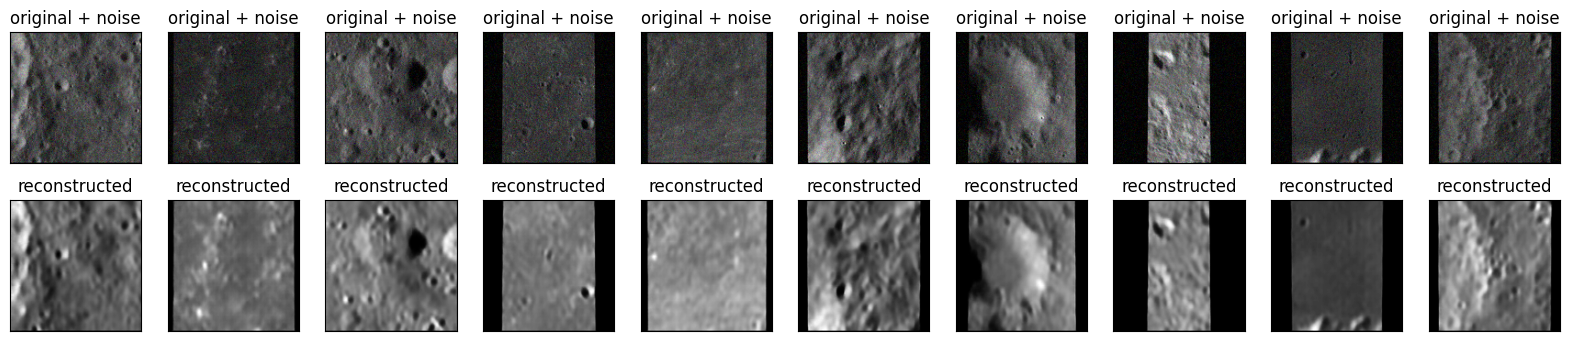

In [21]:
n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
    
plt.show()

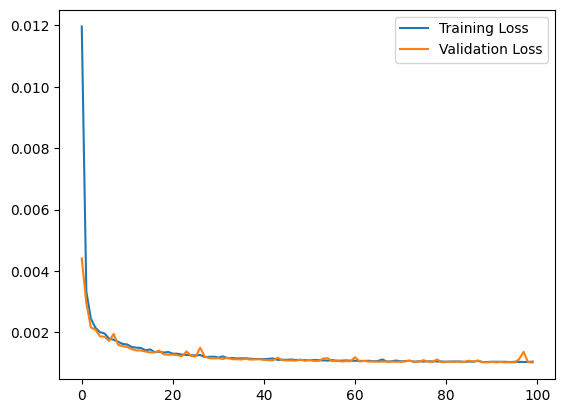

In [22]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()